In [1]:
from IPython.display import display, HTML, clear_output

display(HTML("<style>.container { width:100% !important; }</style>"))


from dataclasses import dataclass, field
import typing as t
import itertools as it
import collections as c
import json
from copy import deepcopy
import math
import time
import functools as ft
import numpy as np
import random
from tqdm.notebook import tqdm
import heapq
import torch as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.tensorboard as tb

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    target_version=black.TargetVersion.PY310,
)

<IPython.core.display.Javascript object>

In [386]:
# Number of past tokens to use to predict next token
CTX_WIN_SZ = 4

## Load data

In [387]:
DOT = "."
words = open("names.txt").read().splitlines()
words[:4]

['emma', 'olivia', 'ava', 'isabella']

#### Build mapping of character to index

In [388]:
def build_ixes(words):
    chars = [DOT] + sorted(set(it.chain.from_iterable(words)))
    nchars = len(chars)
    ctoix = {c: i for i, c in enumerate(chars)}
    ixtoc = dict(enumerate(chars))
    return (ctoix, ixtoc)

In [389]:
(ctoix, ixtoc) = build_ixes(words)

#### Create training data with context window size

In [390]:
DOT

'.'

In [391]:
def build_train_data(words, ctoix, ctx_win=CTX_WIN_SZ):
    Xs, Ys = [], []
    pad = DOT * ctx_win
    for wnum, w in enumerate(words):
        pw = pad + w + DOT
        if wnum < 2:
            print(pw)
        for i in range(len(w) + 1):
            if wnum < 2:
                print(pw[i : i + ctx_win], "--->", pw[i + ctx_win])
            Xs.append([ctoix[c] for c in pw[i : i + ctx_win]])
            Ys.append([ctoix[pw[i + ctx_win]]])
    return T.tensor(Xs, dtype=int), T.tensor(Ys, dtype=int).flatten()

In [392]:
Xs, Ys = build_train_data(words, ctoix, ctx_win=CTX_WIN_SZ)
n, m = Xs.shape
n, m

....emma.
.... ---> e
...e ---> m
..em ---> m
.emm ---> a
emma ---> .
....olivia.
.... ---> o
...o ---> l
..ol ---> i
.oli ---> v
oliv ---> i
livi ---> a
ivia ---> .


(228146, 4)

In [393]:
Ys[:30]

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9])

#### Train, validation, test split

In [394]:
NCHARS = len(ctoix)
NCHARS

27

In [395]:
ntrain, nval = int(n * 0.8), int(n * 0.1)
ntest = n - ntrain - nval
print(f"{ntrain=}, {nval=}, {ntest=}")
ixes = list(range(0, n))
random.shuffle(ixes)
valend = ntrain + nval
ixtr, ixval, ixtest = ixes[:ntrain], ixes[ntrain:valend], ixes[valend:]

ntrain=182516, nval=22814, ntest=22816


In [396]:
(Xtr, Ytr), (Xval, Yval) = (Xs[ixtr], Ys[ixtr]), (Xs[ixval], Ys[ixval])
(Xtest, Ytest) = (Xs[ixtest], Ys[ixtest])

In [397]:
Xtest, Ytest

(tensor([[ 0,  0,  2,  5],
         [14,  1, 12,  1],
         [ 0, 11, 15,  2],
         ...,
         [13,  9, 11, 25],
         [ 0,  0,  0,  0],
         [ 9,  1, 18,  1]]),
 tensor([ 3,  0,  5,  ..., 12, 19,  0]))

In [398]:
print(Xtr.shape, Xval.shape, Xtest.shape)

torch.Size([182516, 4]) torch.Size([22814, 4]) torch.Size([22816, 4])


## Build model and train

- Embedding layer with 3 previous chars (context)
- to fully connected tanh hidden layer (num neuros hyp param)
- to final layer with 27 dim


In [399]:
EMBED_DIM = 4
HIDDEN_DIM = 50

In [400]:
(1 / (HIDDEN_DIM**0.5))

0.1414213562373095

In [524]:
def create_model_params(
    nchrs=NCHARS,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    ctx_win_sz=CTX_WIN_SZ,
    verbose=False,
):
    C = T.randn((nchrs, embed_dim))
    W1 = T.randn(
        (w1_fanin := (embed_dim * ctx_win_sz), hidden_dim),
    ) 
    b1 = T.randn((1, hidden_dim))
    W2 = T.randn(
        (hidden_dim, nchrs),
    ) * (1 / (hidden_dim**0.5))  # shrink final weights to make softmax less confident
    b2 = (
        T.randn(
            (1, nchrs),
        )
        * 0.0 # softmax less confident
    )
    if verbose:
        print(
            f"{ctx_win_sz=}\n{C.shape=}\n{W1.shape=}\n{b1.shape=}\n{W2.shape=}\n{b2.shape=}"
        )
    params = {"C": C, "W1": W1, "b1": b1, "W2": W2, "b2": b2}
    for p in params.values():
        if not p.requires_grad:
            p.requires_grad = True
    return params

In [500]:
mdl = create_model_params(verbose=True)

ctx_win_sz=4
C.shape=torch.Size([27, 4])
W1.shape=torch.Size([16, 50])
b1.shape=torch.Size([1, 50])
W2.shape=torch.Size([50, 27])
b2.shape=torch.Size([1, 27])


In [501]:
_C = mdl["C"]
print(
    f"{Xtr[0]=}\n{_C[0]=}\n{_C[13]=}\n{_C[15]=}\n{(xenc1 := _C[Xtr[:2]])=}\n{xenc1.shape=}"
)

Xtr[0]=tensor([ 8,  1, 13,  9])
_C[0]=tensor([-0.8494,  0.5043, -0.5291, -0.8363], grad_fn=<SelectBackward0>)
_C[13]=tensor([0.8259, 0.9646, 0.0768, 0.5700], grad_fn=<SelectBackward0>)
_C[15]=tensor([-0.3884,  1.0393, -0.2583,  1.1833], grad_fn=<SelectBackward0>)
(xenc1 := _C[Xtr[:2]])=tensor([[[ 0.1688,  0.5719,  1.4013,  1.0010],
         [-1.2762, -1.5546, -1.2126,  0.7487],
         [ 0.8259,  0.9646,  0.0768,  0.5700],
         [-1.2247, -0.2988,  1.1918, -0.6676]],

        [[ 0.3343,  0.2425,  0.4993,  1.3345],
         [-1.2762, -1.5546, -1.2126,  0.7487],
         [ 0.1586, -0.6995,  0.7717,  3.0399],
         [ 1.7477,  0.4229,  0.2160, -0.3604]]], grad_fn=<IndexBackward0>)
xenc1.shape=torch.Size([2, 4, 4])


In [502]:
def fwd_pass(Xs, mdl, act_fn=None):
    act_fn = act_fn or T.tanh
    C, W1, W2, b1, b2 = mdl["C"], mdl["W1"], mdl["W2"], mdl["b1"], mdl["b2"]
    ctx_win, embed_dim = Xs.shape[1], C.shape[1]
    # concat the previous tokens (ctx)
    hidden = act_fn(C[Xs].view(-1, ctx_win * embed_dim) @ W1 + b1)
    logits = hidden @ W2 + b2
    return logits


def fwd_proba(Xs, mdl, act_fn=None):
    return F.softmax(fwd_pass(Xs=Xs, mdl=mdl, act_fn=act_fn), dim=1)

In [503]:
p = F.softmax(fwd_pass(Xs=Xtr[:1], mdl=mdl, act_fn=T.tanh), dim=1)
print(p)
print(p.sum())

tensor([[2.8065e-04, 1.2089e-03, 2.7067e-04, 7.1080e-03, 2.7714e-04, 7.5421e-05,
         9.6319e-01, 5.8660e-03, 5.3592e-05, 9.2741e-06, 1.7018e-06, 1.0321e-03,
         1.7505e-07, 1.2333e-07, 2.1711e-06, 1.2880e-05, 1.2545e-04, 6.2828e-03,
         9.8567e-07, 2.5026e-03, 5.6248e-03, 1.3420e-05, 1.5314e-05, 9.4399e-05,
         5.8877e-03, 5.2073e-05, 1.4998e-05]], grad_fn=<SoftmaxBackward0>)
tensor(1.0000, grad_fn=<SumBackward0>)


In [504]:
def train_loop(
    Xs,
    Ys,
    mdl,
    lr,
    num_iter,
    batch_sz=128,
    losses=None,
    grads=None,
    verbose=True,
):
    # train_ix to loss
    losses = losses if losses is not None else []
    grads = grads or _default_grads(mdl)
    nrows = Xs.shape[0]
    ixes = list(range(nrows))
    if verbose:
        itrs = tqdm(range(num_iter))
    else:
        itrs = range(num_iter)
    total_iter = len(losses)
    for i in itrs:
        total_iter += 1
        random.shuffle(ixes)
        for begix in T.arange(0, nrows, batch_sz):
            batch_ix = ixes[begix : begix + batch_sz]
            p = fwd_pass(Xs=Xs[batch_ix], mdl=mdl)
            loss = F.cross_entropy(input=p, target=Ys[batch_ix])
            losses.append(loss.item())
            _zero_grad(mdl=mdl)
            loss.backward()
            _add_grads(mdl=mdl, grads=grads)
            _update_params(mdl=mdl, lr=_get_lr(lr=lr, it=total_iter))
        if verbose:
            itrs.set_description(f"Loss: {loss.item():.2f}")
    return grads, losses


def _get_lr(lr, it):
    if isinstance(lr, (int, float, T.TensorType, T.Tensor)):
        return lr
    elif isinstance(lr, dict):
        for (min_it, max_it), _lr in lr.items():
            if min_it <= _lr < max_it:
                return _lr
        else:
            raise ValueError(f"Iteration {it} not in any range in {lr}")
    else:
        raise NotImplementedError(
            f"Don't know how to handle learning {lr} of type {type(lr)}"
        )


def _default_grads(mdl):
    return {p: [] for p in mdl}


def _zero_grad(mdl):
    for param in mdl.values():
        param.grad = None


def _update_params(mdl, lr):
    for param in mdl.values():
        param.data -= lr * param.grad


def _add_grads(mdl, grads):
    for pname, param in mdl.items():
        grads[pname].append(param.grad)


def _loss(Xs, Ys, mdl):
    logits = fwd_pass(Xs=Xs, mdl=mdl)
    return F.cross_entropy(input=logits, target=Ys).item()


def _plot_losses(losses: list[int]):
    plt.plot(losses)
    plt.title("Loss vs iteration")
    plt.xlabel("Iter")
    plt.ylabel("Cross entropy or NLL loss")
    plt.grid()


def _plot_grads(grads):
    nparams = len(grads)
    plt.subplots(1, nparams, figsize=(15, 5))
    plt.suptitle("Average grad")
    for i, (param_nm, grad) in enumerate(grads.items(), start=1):
        plt.subplot(1, nparams, i)
        # concatenate on third dim and take mean of grad
        avg_grad = T.cat(
            [T.unsqueeze(g, dim=2) for g in grads[param_nm]], dim=2
        ).mean(dim=2)
        sns.heatmap(avg_grad)
        plt.title(param_nm)


@T.no_grad()
def generate_words(mdl, nwords, ctoix, ctx_win=CTX_WIN_SZ, generator=None):
    st_X = _ctx_to_X(ctx_chars=DOT * CTX_WIN_SZ, ctoix=ctoix).repeat(nwords, 1)
    lst_X = st_X
    words = [[] for _ in range(nwords)]
    for i in range(30):
        # print(f"{lst_X=}")
        new_X = T.multinomial(
            input=F.softmax(fwd_pass(lst_X, mdl), dim=1),
            num_samples=1,
            replacement=True,
            generator=generator,
        )
        # print(f"{new_X=}")
        char_added = False
        for w, ix in zip(words, new_X):
            if w and w[-1] == DOT:
                continue
            char_added |= True
            w.append(ixtoc[ix.item()])
        lst_X[:, :-1] = lst_X[:, 1:]
        lst_X[:, -1] = new_X.squeeze()
        # print(f"{lst_X=}\n\n")
        if not char_added:
            break
    return ["".join(w[:-1]) for w in words]


def num_params(mdl):
    return sum(T.numel(param) for param in mdl.values())


def _ctx_to_X(ctx_chars, ctoix):
    return T.tensor([ctoix[c] for c in ctx_chars]).unsqueeze(dim=0)

In [505]:
@T.no_grad()
def _split_loss(Xtr, Ytr, Xval, Yval, Xtest, Ytest, mdl, split):
    match split:
        case "train":
            spl, loss = "Train", _loss(Xtr, Ytr, mdl)
        case "val":
            spl, loss = "Validation", _loss(Xval, Yval, mdl)
        case "test":
            spl, loss = "Test", _loss(Xtest, Ytest, mdl)
        case _:
            raise NotImplementedError("Split should be train, val or test")
    print(f"{spl} loss={loss:.4f}")


split_loss = ft.partial(
    _split_loss,
    Xtr=Xtr,
    Ytr=Ytr,
    Xval=Xval,
    Yval=Yval,
    Xtest=Xtest,
    Ytest=Ytest,
)

### Test if it works and try to overfit

In [546]:
mdl = create_model_params()
Xtr_sml, Ytr_sml = Xtr[:30], Ytr[:30]

In [547]:
act_fn = T.tanh
C, W1, W2, b1, b2 = mdl["C"], mdl["W1"], mdl["W2"], mdl["b1"], mdl["b2"]
ctx_win, embed_dim = Xtr_sml.shape[1], C.shape[1]
# concat the previous tokens (ctx)
hidden = act_fn(C[Xtr_sml].view(-1, ctx_win * embed_dim) @ W1 + b1)

In [548]:
hidden.shape

torch.Size([30, 50])

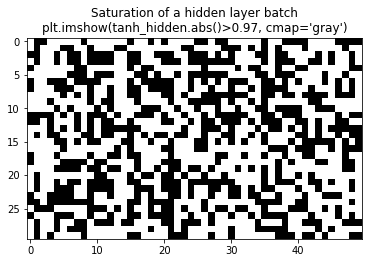

In [554]:
plt.title("Saturation of a hidden layer batch\nplt.imshow(tanh_hidden.abs()>0.97, cmap='gray')")
plt.imshow(hidden.abs()>0.97, cmap='gray');
plt.savefig("/Users/vispers/work/github/psvishnu91.github.io/assets/Images/posts/ml_notes/backprop/saturation.png");

In [521]:
losses, grads = [], _default_grads(mdl)

In [522]:
_ = train_loop(
    Xs=Xtr_sml,
    Ys=Ytr_sml,
    mdl=mdl,
    lr=0.01,
    num_iter=500,
    losses=losses,
    grads=grads,
    batch_sz=10,
)

  0%|          | 0/500 [00:00<?, ?it/s]

In [509]:
losses[:4]

[10.409513473510742, 11.27641487121582, 9.434267044067383, 12.801780700683594]

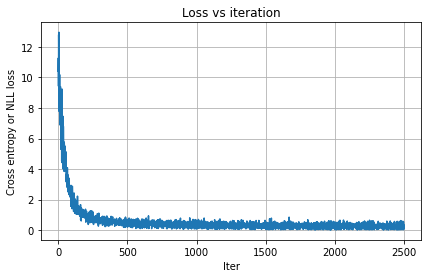

In [525]:
plt.figure(figsize=(15,4))
plt.subplot(121)
_plot_losses(losses)
# plt.title("Loss vs iteration before shrinking weights");
# plt.subplot(122)
# _plot_losses(losses2)
# plt.title("Loss vs iteration after shrinking final layer  weights");

In [413]:
(
    Ytr_sml == T.max(fwd_proba(Xs=Xtr_sml, mdl=mdl), dim=1).indices
).float().mean()

tensor(0.9000)

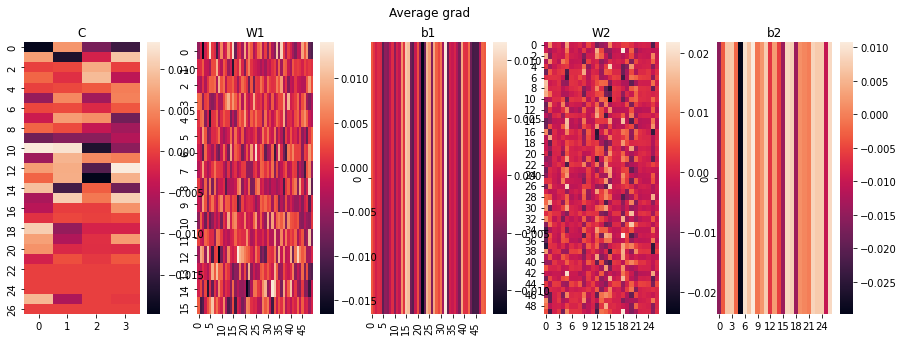

In [414]:
_plot_grads(grads=grads)

### Find best learning rate

In [415]:
# writer = tb.SummaryWriter("experiment-1")
lres = T.linspace(-3, 0.2, 100)
lrs = 10**lres

  0%|          | 0/100 [00:00<?, ?it/s]

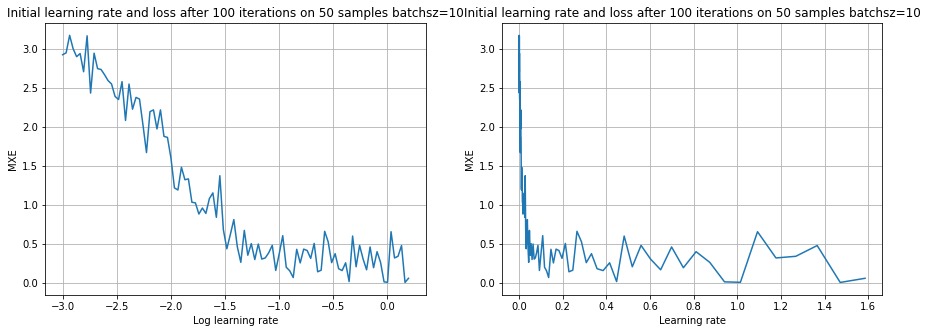

In [416]:
lr_to_loss = []
for lr in tqdm(lrs):
    mdl = create_model_params()
    _, losses = train_loop(
        Xs=Xtr_sml,
        Ys=Ytr_sml,
        mdl=mdl,
        lr=lr,
        num_iter=100,
        losses=[],
        grads=None,
        batch_sz=10,
        verbose=False,
    )
    lr_to_loss.append(losses[-1])
plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(lres, lr_to_loss)
plt.xlabel("Log learning rate")
plt.ylabel("MXE")
plt.grid()
plt.title(
    "Initial learning rate and loss after 100 iterations on 50 samples batchsz=10"
)
plt.subplot(1, 2, 2)
plt.plot(lrs, lr_to_loss)
plt.xlabel("Learning rate")
plt.ylabel("MXE")
plt.grid()
plt.title(
    "Initial learning rate and loss after 100 iterations on 50 samples batchsz=10"
)
plt.show()

### Train on all data

In [461]:
mdl = create_model_params(embed_dim=100, hidden_dim=100)
print(num_params(mdl))
losses, grads = [], _default_grads(mdl)

45527


In [464]:
_ = train_loop(
    Xs=Xtr,
    Ys=Ytr,
    mdl=mdl,
    lr=0.01,
    num_iter=30,
    losses=losses,
    grads=grads,
    batch_sz=1024,
    verbose=True,
)

  0%|          | 0/30 [00:00<?, ?it/s]

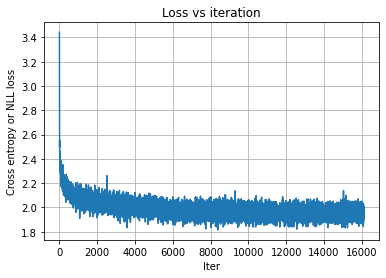

In [465]:
_plot_losses(losses[:])

In [466]:
# _plot_grads(grads)

In [467]:
split_loss(mdl=mdl, split="train")
split_loss(mdl=mdl, split="val")

Train loss=1.9539
Validation loss=2.0639


### Look at low probability predictions in the validation set
Error analysis

In [468]:
val_smax = F.softmax(fwd_pass(Xs=Xval, mdl=mdl), dim=1)
val_p_truech = val_smax[T.arange(len(val_smax)), Yval].detach().numpy()

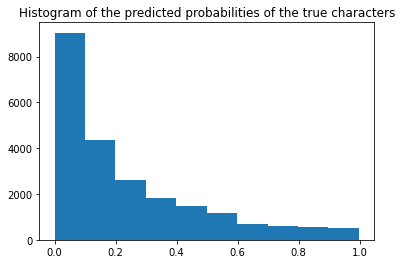

In [469]:
plt.hist(val_p_truech)
plt.title("Histogram of the predicted probabilities of the true characters");

In [470]:
ix_p_low_to_high, p_low_to_high = zip(
    *sorted(enumerate(val_p_truech), key=lambda p: p[1])
)
_n = 20
top_n = list(ix_p_low_to_high[:_n])

In [471]:
for xv, yv, prob in zip(Xval[top_n, :], Yval[top_n], p_low_to_high[:_n]):
    print(
        "".join(ixtoc[ctx.item()] for ctx in xv)
        + " ---> "
        + ixtoc[yv.item()]
        + f"\tP={prob.item():.4f}"
    )

andr ---> z	P=0.0000
kays ---> n	P=0.0000
hayv ---> n	P=0.0000
...h ---> s	P=0.0000
hein ---> r	P=0.0000
rant ---> x	P=0.0000
.liv ---> v	P=0.0001
.ayr ---> t	P=0.0001
tumn ---> r	P=0.0001
rjun ---> r	P=0.0001
khan ---> h	P=0.0001
...d ---> s	P=0.0001
...l ---> j	P=0.0001
yous ---> u	P=0.0002
.nav ---> d	P=0.0002
..ra ---> .	P=0.0002
kayo ---> i	P=0.0002
.abr ---> h	P=0.0002
reta ---> g	P=0.0002
ayle ---> b	P=0.0002


In [472]:
g = T.Generator().manual_seed(2147483647)

In [490]:
gen_words = generate_words(
    mdl=mdl, nwords=10, ctoix=ctoix, ctx_win=CTX_WIN_SZ, generator=g
)
gen_words

['morran',
 'nighan',
 'jersi',
 'keema',
 'keia',
 'blory',
 'michia',
 'jayvin',
 'arsandis',
 'rikan']

In [491]:
set(gen_words) & set(words)

{'jayvin', 'jersi'}

In [492]:
embed = mdl["C"].detach().numpy()
if embed.shape[1] == 2:
    ex, ey = embed[:, 0], embed[:, 1]
    plt.scatter(ex, ey, alpha=0)
    for _x, _y, _c in zip(ex, ey, ixtoc.values()):
        plt.text(_x, _y, _c);

In [493]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [494]:
embed = mdl["C"].detach().numpy()
embed.shape

(27, 100)

In [495]:
embed_tsne = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=3
).fit_transform(embed)
embed_tsne.shape

(27, 2)

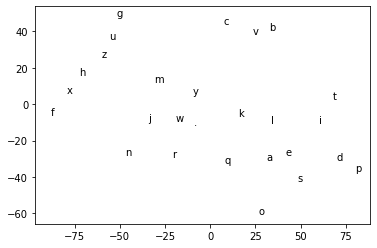

In [496]:
ex, ey = embed_tsne[:, 0], embed_tsne[:, 1]
plt.scatter(ex, ey, alpha=0)
for _x, _y, _c in zip(ex, ey, ixtoc.values()):
    plt.text(_x, _y, _c);

In [497]:
embed_pca = PCA(n_components=2).fit_transform(embed)
embed_pca.shape

(27, 2)

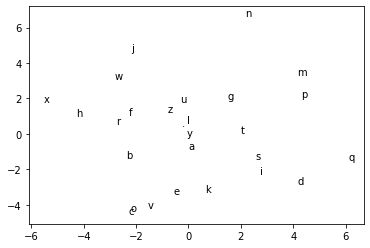

In [498]:
ex, ey = embed_pca[:, 0], embed_pca[:, 1]
plt.scatter(ex, ey, alpha=0)
for _x, _y, _c in zip(ex, ey, ixtoc.values()):
    plt.text(_x, _y, _c);